In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U torchtext==0.6.0

In [ ]:
!pip install tweet-preprocessor

In [ ]:
# base path
DATA_PATH = './drive/MyDrive/FYP_U1821679J/data/subsymbolic/'
SAVED_MODEL_PATH = './drive/MyDrive/FYP_U1821679J/model/'
SAVED_RESULT_PATH = './drive/MyDrive/FYP_U1821679J/results/'

## Libraries

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import torch
from time import time

# Preliminaries
from torch import Tensor
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext import data, datasets
import torch.optim as optim

# Evaluation
from sklearn.metrics import auc, roc_curve, accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# For inference
import spacy
nlp = spacy.load('en')

import sys
sys.path.insert(0, './drive/MyDrive/FYP_U1821679J/')
import data_reader
import results_analyser

# check if it is running with GPU or not
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load the data using custom dataset

In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.Label #if not is_test else None
            text = row.text_cleaned
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, False, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

## Data Handler for RNN models

In [ ]:
# helper function to handle the train and validation data to train the model
def data_handler(root_data_path, train_data_filename, val_data_filename, batch_size=32):
    # defining the fields needed
    TEXT = data.Field(tokenize = 'spacy', batch_first=True, include_lengths = True)
    LABEL = data.LabelField(dtype = torch.float, batch_first=True)
    fields = [('text',TEXT), ('label',LABEL)]

    # load data in pandas dataframe format
    train_data_raw = pd.read_csv(root_data_path + train_data_filename)
    val_data_raw = pd.read_csv(root_data_path + val_data_filename)

    # load the data from pytorch custom dataset class as defined
    train_ds, val_ds = CustomDataset.splits(fields, 
                                            train_df=train_data_raw, 
                                            val_df=val_data_raw)
    
    # defining the vocabulary
    MAX_VOCAB_SIZE = 100000

    TEXT.build_vocab(train_ds, 
                    max_size = MAX_VOCAB_SIZE, 
                    vectors='fasttext.simple.300d',
                    unk_init = torch.Tensor.zero_)
    LABEL.build_vocab(train_ds)

    # No. of unique tokens in text
    print("Size of TEXT vocabulary:",len(TEXT.vocab))

    # No. of unique tokens in label
    print("Size of LABEL vocabulary:",len(LABEL.vocab))

    # Commonly used words
    print(f'Top 10 most frequent word in the vocabulary: {TEXT.vocab.freqs.most_common(10)}')  

    # The whole word dictionary

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    train_iterator, valid_iterator = data.BucketIterator.splits((train_ds, val_ds), 
                                                                batch_size = batch_size, 
                                                                sort_within_batch = True, 
                                                                device = device)
    
    return TEXT, LABEL, device, train_iterator, valid_iterator

## Build Model

In [ ]:
# RNN Models
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, rnn_type, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn_type = rnn_type

        # LSTM
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)
        # GRU
        else:
            self.rnn = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            text_lengths.to('cpu'), 
                                                            batch_first=True)
        # lstm
        if self.rnn_type == 'lstm':
            packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # gru
        else:
            packed_output, hidden = self.rnn(packed_embedded)
            
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                    
        return output

## Training the model

In [ ]:
# helper functions

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# training function 
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    steps = 0
    model.train()
    
    for idx, batch in enumerate(iterator):
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        steps += 1
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        if steps % 50 == 0:
            print (f'Idx: {idx+1}, Train Loss: {loss.item():.4f}')

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    true_list = []
    pred_list = []
    pred_prob_list = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            # keep a record of the prediction and the ground truth value for computation of F1 score
            pred_list.extend(torch.round(torch.sigmoid(predictions)).tolist())
            # get the probability for the ROC Curve instead of the argmax
            pred_prob_list.extend(torch.sigmoid(predictions).tolist())
            true_list.extend(batch.label.tolist())
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), [int(x) for x in true_list], [int(x) for x in pred_list], pred_prob_list

# A function to show f1-score and confusion matrix
def f1_confusion_matrix(true_list, pred_list):
    labels = ['0','1']
    val_tuple = list(zip(true_list, pred_list))
    val_df = pd.DataFrame(val_tuple, columns=['true_list', 'pred_list'])
    # get the multi-class F1-score to see the distribution of the predictions
    print('F1-Score and Confusion Matrix of the Validation Set')
    print()
    print(classification_report(list(val_df['true_list']), list(val_df['pred_list']), target_names=labels, digits=4))
    print('\n')

    # confusion matrix
    cm_sns = pd.crosstab(val_df['true_list'], val_df['pred_list'], rownames=['Actual'], colnames=['Predicted'])
    plt.subplots(figsize=(8,6))
    sns.heatmap(cm_sns, annot=True, fmt="d", cmap='BuGn')
    plt.show()

# get the ROC-AUC values and parameters for the graph
def get_roc_auc(true_list, pred_list):
    fpr, tpr, thresholds = roc_curve(true_list, pred_list)
    get_auc_value = auc(fpr, tpr)
    return fpr, tpr, get_auc_value, thresholds

# train model wrapper
def fit_model(model, device, learning_rate, num_epochs, root_path, filepath):
    
    best_valid_loss = float('inf')
    model.to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate,
                                 weight_decay =1e-4,
                                 eps=1e-7)
    
    # set the LR scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.1, 
                                                           patience=3, 
                                                           min_lr=1e-5,
                                                           verbose=True)
    
    # fixed parameters to perform early stopping
    n_epochs_stop = 3
    epochs_no_improve = 0
    early_stop = False
    min_val_loss = np.inf
    threshold = 0
    epoch_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        # time for every epoch
        t = time()
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, true_list, pred_list, pred_prob_list = evaluate(model, valid_iterator, criterion)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.5f} | Val. Loss: {valid_loss:.5f} | Val. Acc: {valid_acc:.5f} | Time Taken: {time()-t: .3f}s')
        # append the values to plot the graphs
        epoch_list.append(epoch+1)
        train_loss_list.append(train_loss)
        val_loss_list.append(valid_loss)

        # add the scheduler code
        scheduler.step(valid_loss)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), root_path+filepath)
        
         # --- EARLY STOPPING CONDITION ---
        if valid_loss < min_val_loss+threshold: # give some threshold to make the learning less strict
            # resets the no improve counter
            epochs_no_improve = 0
            min_val_loss = valid_loss
        else: # val_loss no improvement
            epochs_no_improve +=1
            print(f"Validation Loss did not improve count: {epochs_no_improve}")
            # set this line as min now
            min_val_loss = valid_loss
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print("Training stopped due to early stopping!")
            break
        else: 
            continue
    
    print()
    # plot the loss curve for both the train and the validation set
    plt.plot(epoch_list, train_loss_list, label='Train')
    plt.plot(epoch_list, val_loss_list, label='Valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show() 

    # get the f1-score and confusion matrix
    f1_confusion_matrix(true_list, pred_list)

    fpr, tpr, get_auc_value, thresholds = get_roc_auc(true_list, pred_prob_list)
    print(f'\nAUC Score: {get_auc_value}')
    
    return fpr, tpr, get_auc_value, thresholds

## Inserting the model configurations to train the model

**Datasets considered**  
- Data1  
- Data4
- Combined 

**Tuned Hyperparameters**   
- Unidirectional vs Bidirectional   
- GRU vs LSTM  

**Total Number of models**   
3 x 2 x 2 = 12 models


## Prepare Datasets created in BERT

In [ ]:
data1_train_filepath = "data1_train.csv"
data1_val_filepath = "data1_val.csv"
data4_train_filepath = "data4_train.csv"
data4_val_filepath = "data4_val.csv"
combined_data_train_filepath = "combined_data_train.csv"
combined_data_val_filepath = "combined_data_val.csv"

In [ ]:
# To generate test results
def predict(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to('cpu')              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor).squeeze(1)       #prediction 
    rounded_preds = torch.round(1-torch.sigmoid(prediction))
    predict_class = rounded_preds.tolist()[0]

    return predict_class   

results_df = pd.DataFrame()
data2 = data_reader.read_data2("dataframe", True)
data3 = data_reader.read_data3("dataframe", True)

./drive/MyDrive/FYP_U1821679J/data_reader.py:60: FutureWarning: The default value of regex will change from True to False in a future version.
  stocktwit_df[col_name] = stocktwit_df[col_name].str.replace(r'([$][a-zA-z\.]{1,8})', '')
./drive/MyDrive/FYP_U1821679J/data_reader.py:70: FutureWarning: The default value of regex will change from True to False in a future version.
  stocktwit_df[col_name] = stocktwit_df[col_name].str.replace(r'(@[^\s]+|[#]|[$])', ' ')  # Replace '@', '$' and '#...'
./drive/MyDrive/FYP_U1821679J/data_reader.py:71: FutureWarning: The default value of regex will change from True to False in a future version.
  stocktwit_df[col_name] = stocktwit_df[col_name].str.replace(r'(\n|\r)', ' ')  # Replace page breaks
./drive/MyDrive/FYP_U1821679J/data_reader.py:74: FutureWarning: The default value of regex will change from True to False in a future version.
  stocktwit_df[col_name] = stocktwit_df[col_name].str.replace(r'((https:|http:)[^\s]+|(www\.)[^\s]+)', ' ')
./drive

### CONFIGURATION 1a
**Baseline**  
- Data 1
- Uni-LSTM

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda
RNN(
  (embedding): Embedding(3286, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 9,481,929 trainable parameters

Idx: 50, Train Loss: 0.7170
Epoch 1: Train Loss: 0.68122 | Val. Loss: 0.67062 | Val. Acc: 0.66060 | Time Taken:  2.199s
Idx: 50, Train Loss: 0.7436
Epoch 2: Train Loss: 0.67078 | Val. Loss: 0.64631 | Val. Acc: 0.66060 | Time Taken:  2.103s
Idx: 50, Train Loss: 0.6557
Epoch 3: Train Loss: 0.67760 | Val. Loss: 0.65100 | Val. Acc: 0.66060 | Time Taken:  2.250s
Validation Loss did not improve count: 1
Idx: 50, Train Lo

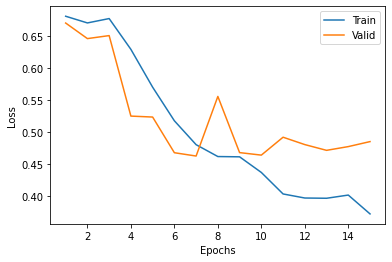

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8577    0.8321    0.8447       268
           1     0.6897    0.7299    0.7092       137

    accuracy                         0.7975       405
   macro avg     0.7737    0.7810    0.7770       405
weighted avg     0.8009    0.7975    0.7989       405





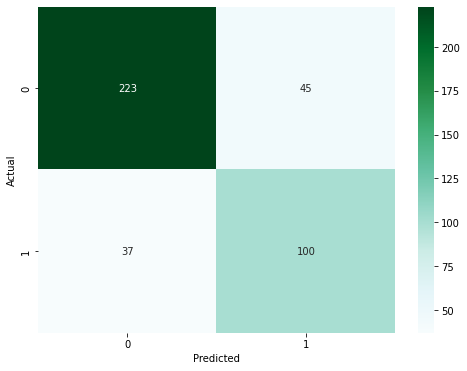


AUC Score: 0.8445500599193813


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_unilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1a, tpr1a, get_auc_value1a, thresholds1a = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_unilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda


### CONFIGURATION 1b
- Data 1
- BiLSTM

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda
RNN(
  (embedding): Embedding(3286, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 23,744,201 trainable parameters

Idx: 50, Train Loss: 0.7296
Epoch 1: Train Loss: 0.67792 | Val. Loss: 0.65682 | Val. Acc: 0.66060 | Time Taken:  4.393s
Idx: 50, Train Loss: 0.7719
Epoch 2: Train Loss: 0.68016 | Val. Loss: 0.65746 | Val. Acc: 0.68945 | Time Taken:  4.152s
Validation Loss did not improve count: 1
Idx: 50, Train Loss: 0.4857
Epoch 3: Train Loss: 0.64856 | Val. Loss: 0.53141 | Val. Acc: 0.72779 | Time Taken:  4.1

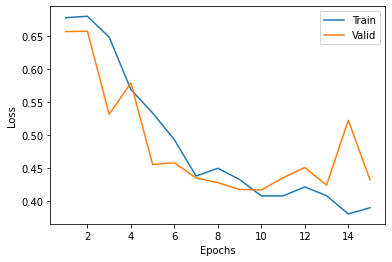

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8524    0.8619    0.8571       268
           1     0.7239    0.7080    0.7159       137

    accuracy                         0.8099       405
   macro avg     0.7881    0.7850    0.7865       405
weighted avg     0.8089    0.8099    0.8094       405





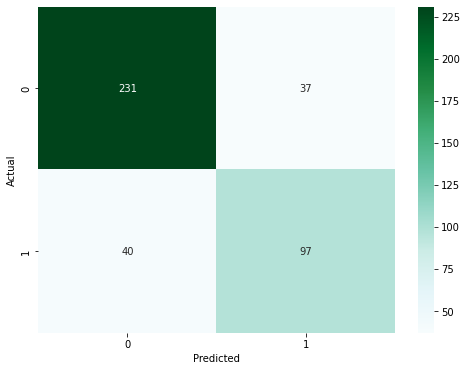


AUC Score: 0.8692259505392745


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1b, tpr1b, get_auc_value1b, thresholds1b = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda


### CONFIGURATION 1c
- Data 1
- Uni-GRU

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda
RNN(
  (embedding): Embedding(3286, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 7,489,225 trainable parameters

Idx: 50, Train Loss: 0.6868
Epoch 1: Train Loss: 0.67633 | Val. Loss: 0.62912 | Val. Acc: 0.66060 | Time Taken:  1.891s
Idx: 50, Train Loss: 0.6214
Epoch 2: Train Loss: 0.63982 | Val. Loss: 0.58440 | Val. Acc: 0.72070 | Time Taken:  1.772s
Idx: 50, Train Loss: 0.6532
Epoch 3: Train Loss: 0.59566 | Val. Loss: 0.52020 | Val. Acc: 0.74222 | Time Taken:  1.745s
Idx: 50, Train Loss: 0.6530
Epoch 4: Train Loss: 0.56040 | 

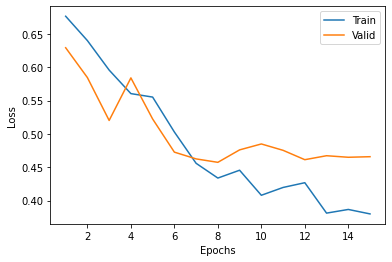

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8534    0.8470    0.8502       268
           1     0.7050    0.7153    0.7101       137

    accuracy                         0.8025       405
   macro avg     0.7792    0.7812    0.7802       405
weighted avg     0.8032    0.8025    0.8028       405





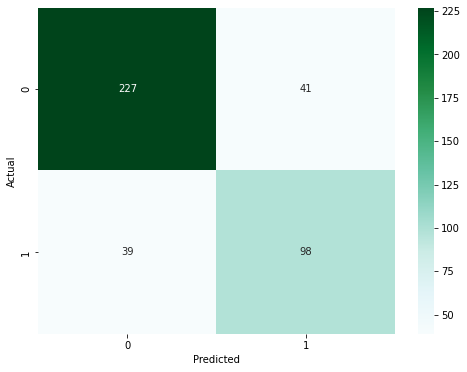


AUC Score: 0.8415268547772089


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_unigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1c, tpr1c, get_auc_value1c, thresholds1c = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_unigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda


### CONFIGURATION 1d 
- Data 1
- BiGRU

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda
RNN(
  (embedding): Embedding(3286, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 18,185,929 trainable parameters

Idx: 50, Train Loss: 0.6742
Epoch 1: Train Loss: 0.68014 | Val. Loss: 0.65128 | Val. Acc: 0.68098 | Time Taken:  3.571s
Idx: 50, Train Loss: 0.5893
Epoch 2: Train Loss: 0.66247 | Val. Loss: 0.63981 | Val. Acc: 0.61596 | Time Taken:  3.446s
Idx: 50, Train Loss: 0.5133
Epoch 3: Train Loss: 0.60985 | Val. Loss: 0.51527 | Val. Acc: 0.76500 | Time Taken:  3.436s
Idx: 50, Train Loss: 0.5476
Epoch 4: T

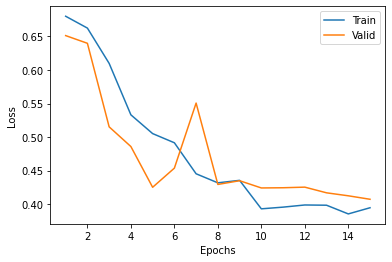

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8623    0.8881    0.8750       268
           1     0.7674    0.7226    0.7444       137

    accuracy                         0.8321       405
   macro avg     0.8149    0.8053    0.8097       405
weighted avg     0.8302    0.8321    0.8308       405





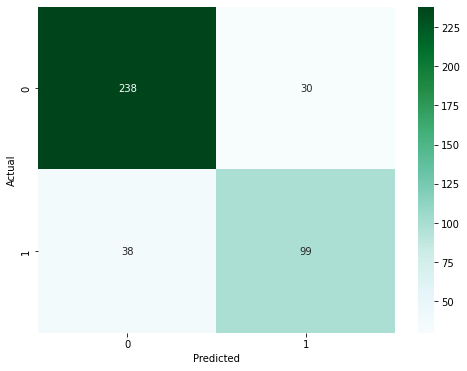


AUC Score: 0.8797663144133347


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1d, tpr1d, get_auc_value1d, thresholds1d = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data1_train_filepath, 
                                                                   val_data_filename=data1_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data1_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 3286
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 417), ('to', 410), ('a', 311), ('in', 268), ('of', 267), ('on', 253), ('for', 251), ('and', 227), ('is', 212), ('this', 148)]
cuda


### CONFIGURATION 2a
- Data 4
- Uni-LSTM

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda
RNN(
  (embedding): Embedding(5931, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 10,275,429 trainable parameters

Idx: 50, Train Loss: 0.6988
Idx: 100, Train Loss: 0.6090
Epoch 1: Train Loss: 0.65365 | Val. Loss: 0.62209 | Val. Acc: 0.73250 | Time Taken:  4.869s
Idx: 50, Train Loss: 0.5716
Idx: 100, Train Loss: 0.5235
Epoch 2: Train Loss: 0.64557 | Val. Loss: 0.59008 | Val. Acc: 0.73250 | Time Taken:  4.772s
Idx: 50, Train Loss: 0.6661
Idx: 100, Train Loss: 0.4840
Epoch 3: Train Loss: 0.63862 | Val. Loss: 0.57539 | Val. Acc: 

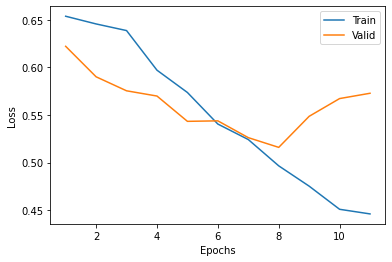

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7975    0.8874    0.8401       586
           1     0.5541    0.3832    0.4530       214

    accuracy                         0.7525       800
   macro avg     0.6758    0.6353    0.6466       800
weighted avg     0.7324    0.7525    0.7365       800





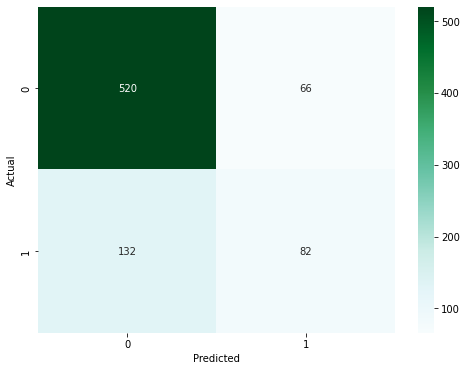


AUC Score: 0.7208781219099869


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_unilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2a, tpr2a, get_auc_value2a, thresholds2a = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_unilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda


### CONFIGURATION 2b
- Data 4
- BiLSTM

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda
RNN(
  (embedding): Embedding(5931, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 24,537,701 trainable parameters

Idx: 50, Train Loss: 0.5551
Idx: 100, Train Loss: 0.6485
Epoch 1: Train Loss: 0.64476 | Val. Loss: 0.63588 | Val. Acc: 0.73250 | Time Taken:  10.074s
Idx: 50, Train Loss: 0.5721
Idx: 100, Train Loss: 0.6166
Epoch 2: Train Loss: 0.64636 | Val. Loss: 0.60370 | Val. Acc: 0.73250 | Time Taken:  10.009s
Idx: 50, Train Loss: 0.6292
Idx: 100, Train Loss: 0.5547
Epoch 3: Train Loss: 0.63776 | Val. Loss

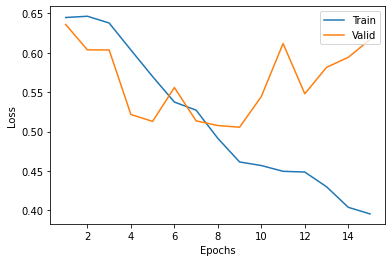

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8095    0.8123    0.8109       586
           1     0.4811    0.4766    0.4789       214

    accuracy                         0.7225       800
   macro avg     0.6453    0.6445    0.6449       800
weighted avg     0.7217    0.7225    0.7221       800





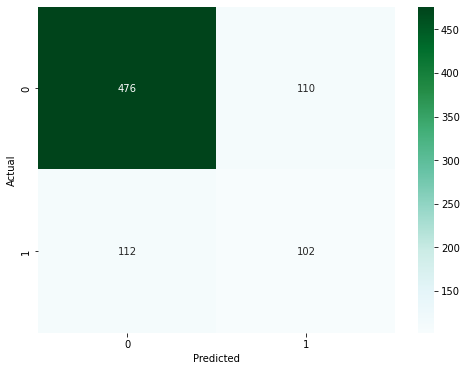


AUC Score: 0.7192753022232146


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2b, tpr2b, get_auc_value2b, thresholds2b = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda


### CONFIGURATION 2c
- Data 4
- Uni-GRU

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda
RNN(
  (embedding): Embedding(5931, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 8,282,725 trainable parameters

Idx: 50, Train Loss: 0.6561
Idx: 100, Train Loss: 0.6476
Epoch 1: Train Loss: 0.66179 | Val. Loss: 0.63563 | Val. Acc: 0.73250 | Time Taken:  4.327s
Idx: 50, Train Loss: 0.4800
Idx: 100, Train Loss: 0.5730
Epoch 2: Train Loss: 0.63802 | Val. Loss: 0.57351 | Val. Acc: 0.75500 | Time Taken:  4.212s
Idx: 50, Train Loss: 0.6927
Idx: 100, Train Loss: 0.5605
Epoch 3: Train Loss: 0.61700 | Val. Loss: 0.60503 | Val. Acc: 0.

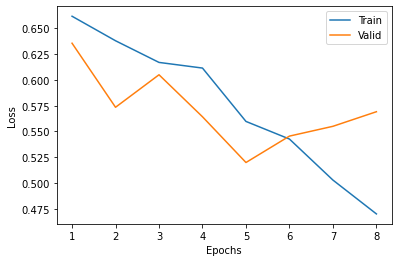

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7869    0.9198    0.8482       586
           1     0.5913    0.3178    0.4134       214

    accuracy                         0.7588       800
   macro avg     0.6891    0.6188    0.6308       800
weighted avg     0.7345    0.7588    0.7318       800





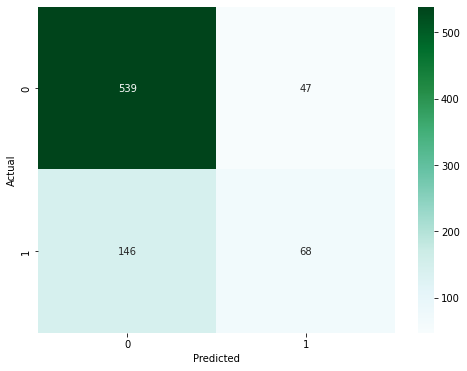


AUC Score: 0.7079439252336449


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_unigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2c, tpr2c, get_auc_value2c, thresholds2c = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_unigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda


### CONFIGURATION 2d
- Data 4
- BiGRU

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda
RNN(
  (embedding): Embedding(5931, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 18,979,429 trainable parameters

Idx: 50, Train Loss: 0.6051
Idx: 100, Train Loss: 0.6417
Epoch 1: Train Loss: 0.66166 | Val. Loss: 0.59666 | Val. Acc: 0.73375 | Time Taken:  8.550s
Idx: 50, Train Loss: 0.5460
Idx: 100, Train Loss: 0.5389
Epoch 2: Train Loss: 0.63922 | Val. Loss: 0.57209 | Val. Acc: 0.75000 | Time Taken:  8.457s
Idx: 50, Train Loss: 0.5519
Idx: 100, Train Loss: 0.6500
Epoch 3: Train Loss: 0.62054 | Val. Loss: 0

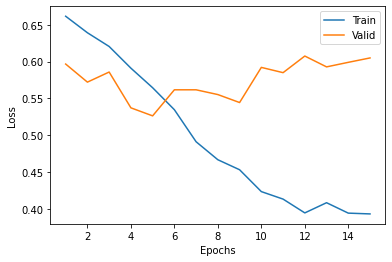

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7936    0.8464    0.8192       586
           1     0.4857    0.3972    0.4370       214

    accuracy                         0.7262       800
   macro avg     0.6397    0.6218    0.6281       800
weighted avg     0.7112    0.7262    0.7169       800





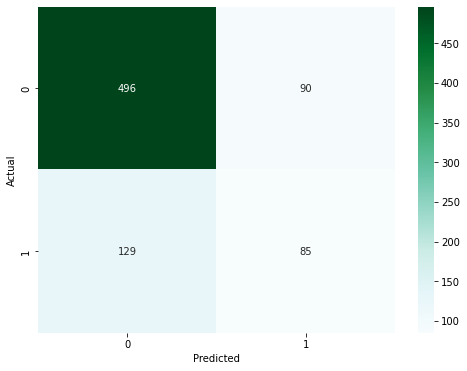


AUC Score: 0.7046186724506396


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2d, tpr2d, get_auc_value2d, thresholds2d = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=data4_train_filepath, 
                                                                   val_data_filename=data4_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'data4_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5931
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1712), ('to', 1238), ('and', 861), ('a', 822), ('is', 813), ('i', 643), ('this', 634), ('in', 596), ('of', 580), ('it', 478)]
cuda


### CONFIGURATION 3a
- Combined Data 1 and 4
- Uni-LSTM

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda
RNN(
  (embedding): Embedding(5711, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 10,209,429 trainable parameters

Idx: 50, Train Loss: 0.6147
Idx: 100, Train Loss: 0.6749
Epoch 1: Train Loss: 0.66656 | Val. Loss: 0.63698 | Val. Acc: 0.71154 | Time Taken:  4.692s
Idx: 50, Train Loss: 0.6241
Idx: 100, Train Loss: 0.6028
Epoch 2: Train Loss: 0.66352 | Val. Loss: 0.61895 | Val. Acc: 0.71154 | Time Taken:  4.569s
Idx: 50, Train Loss: 0.5782
Idx: 100, Train Loss: 0.5909
Epoch 3: Train Loss: 0.64357 | Val. Loss: 0.62805 | Val. Acc

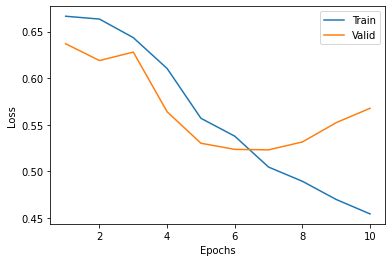

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8127    0.7972    0.8049       577
           1     0.5165    0.5411    0.5285       231

    accuracy                         0.7240       808
   macro avg     0.6646    0.6692    0.6667       808
weighted avg     0.7280    0.7240    0.7259       808





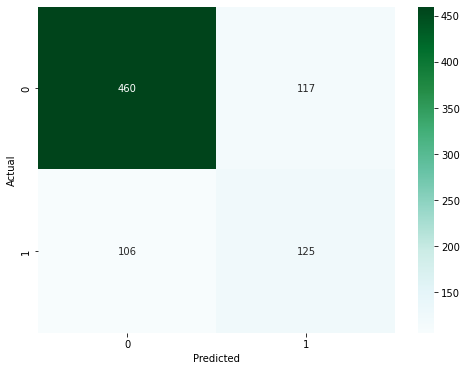


AUC Score: 0.7467007285031548


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_unilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3a, tpr3a, get_auc_value3a, thresholds3a = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_unilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda


### CONFIGURATION 3b
-  Combined Data 1 and 4
- Bi-LSTM

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda
RNN(
  (embedding): Embedding(5711, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 24,471,701 trainable parameters

Idx: 50, Train Loss: 0.6584
Idx: 100, Train Loss: 0.7147
Epoch 1: Train Loss: 0.66086 | Val. Loss: 0.64236 | Val. Acc: 0.71154 | Time Taken:  9.546s
Idx: 50, Train Loss: 0.7026
Idx: 100, Train Loss: 0.5149
Epoch 2: Train Loss: 0.65769 | Val. Loss: 0.54724 | Val. Acc: 0.75601 | Time Taken:  9.450s
Idx: 50, Train Loss: 0.5985
Idx: 100, Train Loss: 0.4896
Epoch 3: Train Loss: 0.61924 | Val. Loss

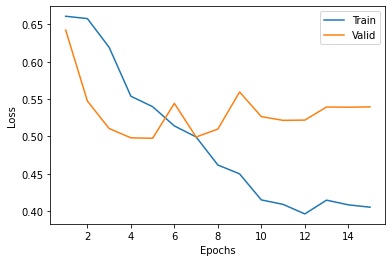

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8187    0.8215    0.8201       577
           1     0.5502    0.5455    0.5478       231

    accuracy                         0.7426       808
   macro avg     0.6844    0.6835    0.6839       808
weighted avg     0.7419    0.7426    0.7422       808





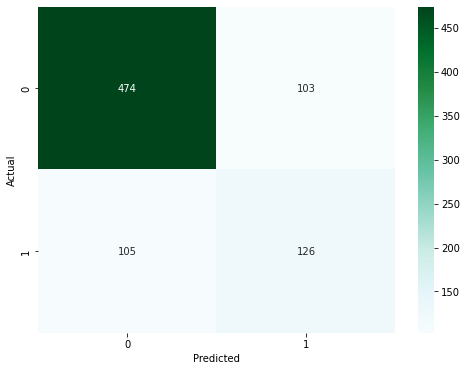


AUC Score: 0.7879275548253017


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3b, tpr3b, get_auc_value3b, thresholds3b = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda


### CONFIGURATION 3c
-  Combined Data 1 and 4
- Uni-GRU

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda
RNN(
  (embedding): Embedding(5711, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 8,216,725 trainable parameters

Idx: 50, Train Loss: 0.6058
Idx: 100, Train Loss: 0.7317
Epoch 1: Train Loss: 0.66600 | Val. Loss: 0.62567 | Val. Acc: 0.71154 | Time Taken:  4.128s
Idx: 50, Train Loss: 0.7917
Idx: 100, Train Loss: 0.5814
Epoch 2: Train Loss: 0.65136 | Val. Loss: 0.56580 | Val. Acc: 0.74038 | Time Taken:  3.987s
Idx: 50, Train Loss: 0.6263
Idx: 100, Train Loss: 0.5769
Epoch 3: Train Loss: 0.61776 | Val. Loss: 0.58359 | Val. Acc: 

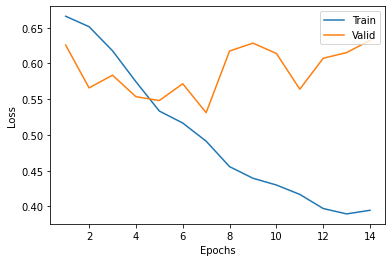

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8140    0.8042    0.8091       577
           1     0.5252    0.5411    0.5330       231

    accuracy                         0.7290       808
   macro avg     0.6696    0.6726    0.6711       808
weighted avg     0.7315    0.7290    0.7302       808





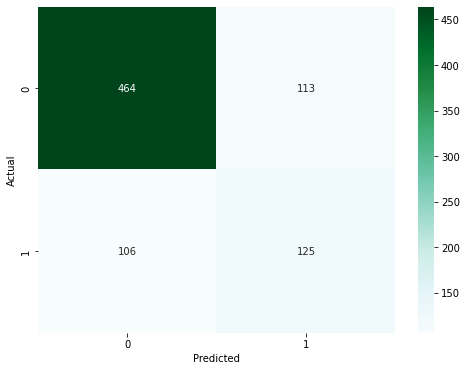


AUC Score: 0.7345164944818324


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_unigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3c, tpr3c, get_auc_value3c, thresholds3c = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_unigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda


### CONFIGURATION 3d
-  Combined Data 1 and 4
- BiGRU

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda
RNN(
  (embedding): Embedding(5711, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 18,913,429 trainable parameters

Idx: 50, Train Loss: 0.6490
Idx: 100, Train Loss: 0.7185
Epoch 1: Train Loss: 0.68121 | Val. Loss: 0.63737 | Val. Acc: 0.72476 | Time Taken:  8.091s
Idx: 50, Train Loss: 0.6052
Idx: 100, Train Loss: 0.6470
Epoch 2: Train Loss: 0.64903 | Val. Loss: 0.54633 | Val. Acc: 0.74279 | Time Taken:  8.016s
Idx: 50, Train Loss: 0.6203
Idx: 100, Train Loss: 0.4317
Epoch 3: Train Loss: 0.59910 | Val. Loss:

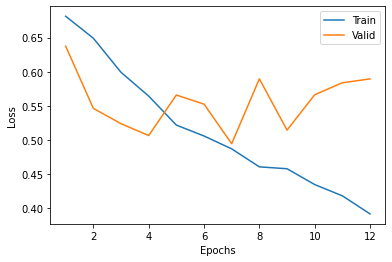

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8080    0.8024    0.8052       577
           1     0.5149    0.5238    0.5193       231

    accuracy                         0.7228       808
   macro avg     0.6615    0.6631    0.6623       808
weighted avg     0.7242    0.7228    0.7235       808





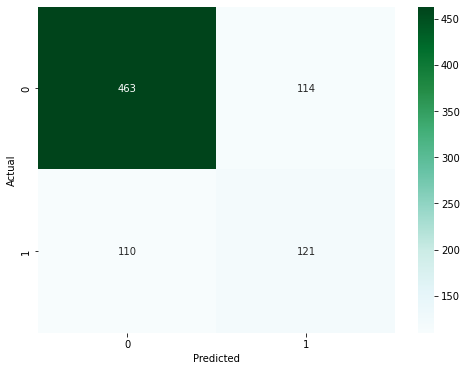


AUC Score: 0.7690885082566192


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3d, tpr3d, get_auc_value3d, thresholds3d = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename=combined_data_train_filepath, 
                                                                   val_data_filename=combined_data_val_filepath, 
                                                                   batch_size=32)

MODEL_NAME = 'combined_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

PATH = SAVED_MODEL_PATH+MODEL_NAME
model.load_state_dict(torch.load(PATH))

data2_pred = []
data3_pred = []

for sentence in data2['text_cleaned'].to_list():
    data2_pred.append(predict(model, sentence))
for sentence in data3['text_cleaned'].to_list():
    data3_pred.append(predict(model, sentence))

results_df = results_analyser.calculate_metrics(results_df, data2["Label"].to_list(), data2_pred, "data2_"+MODEL_NAME)
results_df = results_analyser.calculate_metrics(results_df, data3["Label"].to_list(), data3_pred, "data3_"+MODEL_NAME)

Size of TEXT vocabulary: 5711
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('the', 1271), ('to', 1042), ('a', 694), ('and', 651), ('is', 633), ('in', 573), ('of', 549), ('this', 516), ('for', 500), ('on', 477)]
cuda


## View and save results

In [ ]:
display(results_df)

,Experiment,Accuracy,Precision,Recall,F1_score
0,data2_data1_unilstm_model.pt,0.674286,0.696429,0.814042,0.750656
1,data3_data1_unilstm_model.pt,0.612403,0.659664,0.694690,0.676724
2,data2_data1_bilstm_model.pt,0.674286,0.695161,0.817837,0.751526
3,data3_data1_bilstm_model.pt,0.621878,0.672439,0.687316,0.679796
4,data2_data1_unigru_model.pt,0.656000,0.657382,0.895636,0.758233
5,data3_data1_unigru_model.pt,0.624462,0.640046,0.815634,0.717250
6,data2_data1_bigru_model.pt,0.698286,0.733570,0.783681,0.757798
7,data3_data1_bigru_model.pt,0.624462,0.676385,0.684366,0.680352
8,data2_data4_unilstm_model.pt,0.646857,0.650552,0.893738,0.752998
9,data3_data4_unilstm_model.pt,0.677864,0.658664,0.930678,0.771394


In [ ]:
results_df.to_csv(SAVED_RESULT_PATH+'rnn_test.csv', index=False)

## Fill up the dataframe of saved values for ROC curve


In [ ]:
# helper function to to plot the ROC curve
def plot_roc(fpr, tpr, auc_value): # pass in a subset of the list
    """
    - Print AUC
    - Plot ROC
    """
    color_set = ['b','g','r','k']
    label_name = ['UniLSTM', 'BiLSTM', 'UniGRU', 'BiGRU']
    # Plot ROC AUC
    print('ROC Curve')
    plt.rcParams["figure.figsize"] = [12,8]
    plt.title('Receiver Operating Characteristic')
    for i in range(len(auc_value)):
        plt.plot(fpr[i], tpr[i], color_set[i], label = f'{label_name[i]} AUC = {auc_value[i]:.4f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# collate the values in a list for backup
fpr_list = [fpr1a,fpr1b,fpr1c,fpr1d,
            fpr2a,fpr2b,fpr2c,fpr2d,
            fpr3a,fpr3b,fpr3c,fpr3d]

tpr_list = [tpr1a,tpr1b,tpr1c,tpr1d,
            tpr2a,tpr2b,tpr2c,tpr2d,
            tpr3a,tpr3b,tpr3c,tpr3d]

get_auc_value_list = [get_auc_value1a,get_auc_value1b,get_auc_value1c,get_auc_value1d,
                      get_auc_value2a,get_auc_value2b,get_auc_value2c,get_auc_value2d,
                      get_auc_value3a,get_auc_value3b,get_auc_value3c,get_auc_value3d]

thresholds_list = [thresholds1a,thresholds1b,thresholds1c,thresholds1d,
                   thresholds2a,thresholds2b,thresholds2c,thresholds2d,
                   thresholds3a,thresholds3b,thresholds3c,thresholds3d]

# create a dataframe to store all the values
roc_auc_df = pd.DataFrame()
roc_auc_df['fpr'] = fpr_list
roc_auc_df['tpr'] = tpr_list
roc_auc_df['get_auc_value'] = get_auc_value_list
roc_auc_df['thresholds'] = thresholds_list

# export dataframe as backup
roc_auc_df.to_csv(SAVED_RESULT_PATH+'rnn_roc_auc.csv', index=False)

## Get the 4 sets of ROC Curve for different dataset

ROC Curve


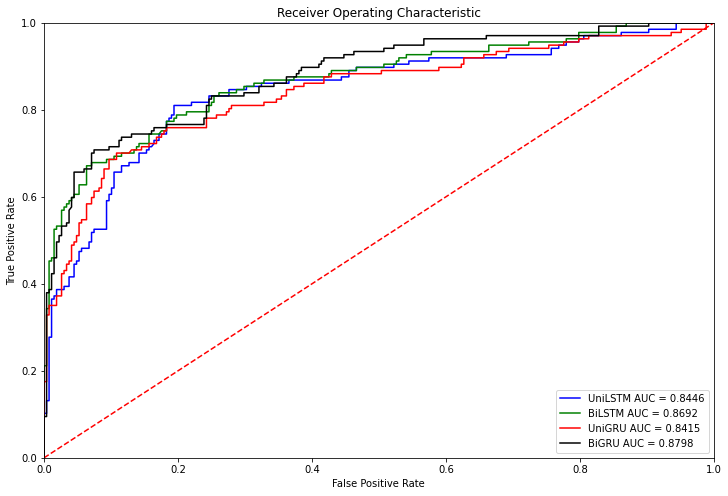

In [ ]:
# data1
plot_roc(fpr_list[:4], tpr_list[:4], get_auc_value_list[:4])

ROC Curve


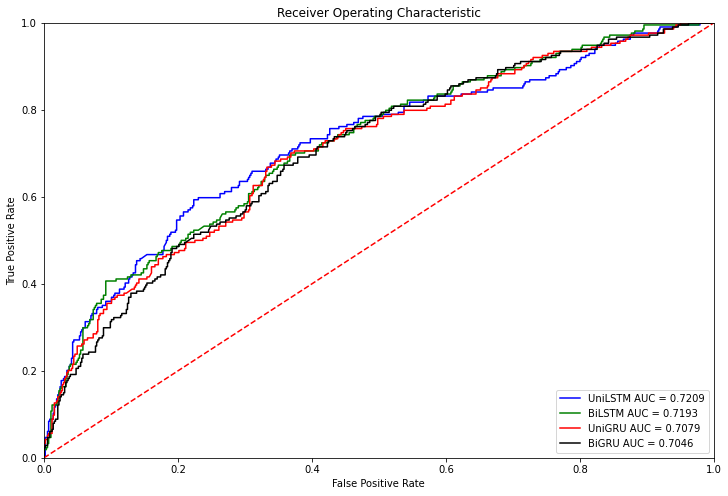

In [ ]:
# data4
plot_roc(fpr_list[4:8], tpr_list[4:8], get_auc_value_list[4:8])

ROC Curve


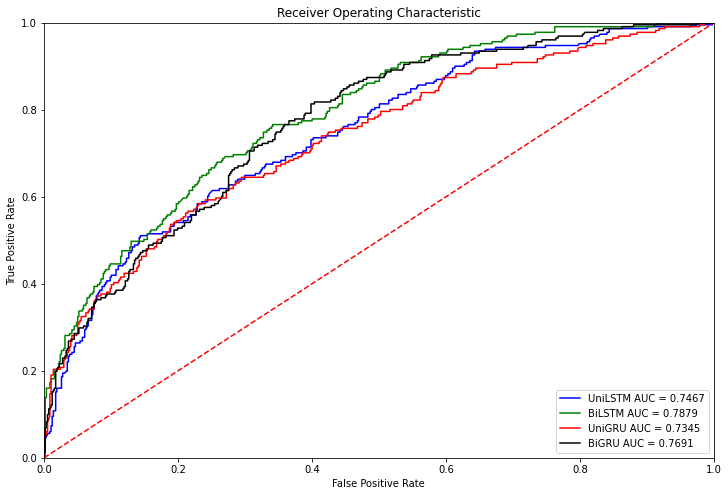

In [ ]:
# combined
plot_roc(fpr_list[8:12], tpr_list[8:12], get_auc_value_list[8:12])